# Relationship between income and educational attainment

The goal is to investigate the relationship between income and educational attainment using US census data. The target of inference is the poisson regression coefficient when regressing yearly income in dollars on educational attainment, while controlling for sex. The data from California in the year 2019 is downloaded through the Folktables interface (1). Predictions of educational attainment are made by training a gradient boosting tree via XGBoost (2) with a Poisson regression loss on the previous year’s data.

1. F. Ding, M. Hardt, J. Miller, L. Schmidt, “Retiring adult: New datasets for fair machine learning” in Advances in Neural Information Processing Systems 34 (2021), pp. 6478–6490.
2. T. Chen, C. Guestrin, “XGBoost: A scalable tree boosting system” in Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (2016), pp. 785–794.

### Import necessary packages

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)))
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_poisson_ci, classical_poisson_ci
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from scipy.optimize import brentq
import seaborn as sns
from tqdm import tqdm
from utils import *

### Import the census income data set

Load the data. The data set contains reported income (```Y```), predicted income (```Yhat```), and age and sex (```X```).

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.1
coordinate = 0  # Choose between 0, 1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(100, 2000, 5).astype(
    int
)  # Test for different numbers of labeled incomes
num_trials = 100
# Compute ground truth
scaler = StandardScaler()

# Compute ground truth
reg = PoissonRegressor(alpha=0, fit_intercept=False, max_iter=1000, tol=1e-10)
true_theta = reg.fit(X_total, Y_total).coef_.squeeze()[coordinate]

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _X = X_total[rand_idx[:n]]
        _X_unlabeled = X_total[rand_idx[n:]]
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        ppi_ci = ppi_poisson_ci(_X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, lam=1, alpha=alpha)
        ppi_ci_tuned = ppi_poisson_ci(_X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha)

        # Classical interval
        classical_ci = classical_poisson_ci(_X, _Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "included": (ppi_ci[0][coordinate] <= true_theta)
                        & (ppi_ci[1][coordinate] >= true_theta),
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI++",
                        "n": n,
                        "lower": ppi_ci_tuned[0][coordinate],
                        "upper": ppi_ci_tuned[1][coordinate],
                        "included": (ppi_ci_tuned[0][coordinate] <= true_theta)
                        & (ppi_ci_tuned[1][coordinate] >= true_theta),
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "included": (classical_ci[0][coordinate] <= true_theta)
                        & (classical_ci[1][coordinate] >= true_theta),
                        "trial": j,
                    }
                ]
            )
        ]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|██████████| 5/5 [1:56:58<00:00, 1403.77s/it]  


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

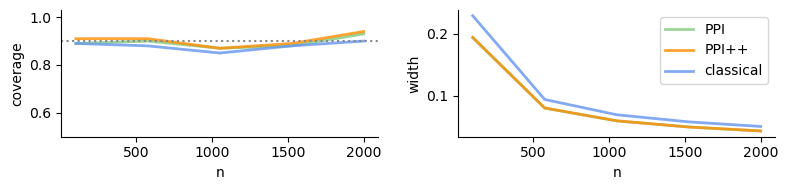

In [5]:
palette = {
    "PPI++": "darkorange",
    "PPI": "#83C980",
    "classical": "cornflowerblue",
}
linewidth = 2

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 2), sharex=True)
cvg_ax = axs[0]
sz_ax = axs[1]
sns.lineplot(
    ax=cvg_ax,
    data=df,
    x="n",
    y="included",
    linewidth=linewidth,
    errorbar=None,
    hue="method",
    legend=False,
    palette=palette,
    alpha=0.8,
)
sns.lineplot(
    ax=sz_ax,
    data=df,
    x="n",
    y="width",
    linewidth=linewidth,
    errorbar=None,
    hue="method",
    legend=True,
    palette=palette,
    alpha=0.8,
)
cvg_ax.set_ylabel("coverage")
cvg_ax.set_ylim([0.5, 1.03])
cvg_ax.axhline(y=1 - alpha, color="#888888", linestyle="dotted")
cvg_ax.set_xlabel("n")
sz_ax.set_ylabel("width")
sz_ax.legend_.set_title(None)
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs("./plots", exist_ok=True)
plt.savefig("./plots/tuned-PPI-education.pdf")

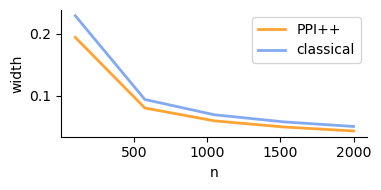

In [6]:
palette = {
    "PPI++": "darkorange",
    "classical": "cornflowerblue",
}
linewidth = 2

teaser_df = df[df["method"].isin(["PPI++", "classical"])]

fig = plt.figure(figsize=(4, 2))
sns.lineplot(
    ax=plt.gca(),
    data=teaser_df,
    x="n",
    y="width",
    linewidth=linewidth,
    errorbar=None,
    hue="method",
    legend=True,
    palette=palette,
    alpha=0.8,
)
plt.gca().set_ylabel("width")
plt.gca().legend_.set_title(None)
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs("./plots", exist_ok=True)
plt.savefig("./plots/teaser-tuned-census-education.pdf")